In [18]:
print(len(np.where(ss == 0)[1]))
print(len(np.where(ss == 1)[1]))
print(len(np.where(ss == 2)[1]))

726
542
170


In [19]:
print(cluster_labels)
print(sum(cluster_labels == 0))
print(sum(cluster_labels == 1))
print(sum(cluster_labels == 2))

[0 0 0 ... 1 1 1]
726
542
170


In [20]:
print(X_pca.shape)

(1438, 3)


Common date columns: ['2017-07-01', '2017-07-02', '2017-07-10', '2017-08-02', '2017-08-18', '2017-08-20', '2017-09-04', '2017-09-05', '2017-09-06', '2017-09-09', '2017-09-10', '2017-09-19', '2017-10-05', '2017-10-21', '2017-10-28', '2017-10-29', '2017-11-08', '2017-11-26', '2017-12-29', '2017-12-30', '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-13', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-29', '2018-01-30', '2018-02-02', '2018-02-03', '2018-02-07', '2018-02-09', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-18', '2018-02-19', '2018-02-23', '2018-02-24', '2018-02-26', '2018-02-27', '2018-03-02', '2018-03-03', '2018-03-05', '2018-03-06', '2018-03-08', '2018-03-10', '2018-03-14', '2018-03-16', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-23', '2018-03-24', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-15'

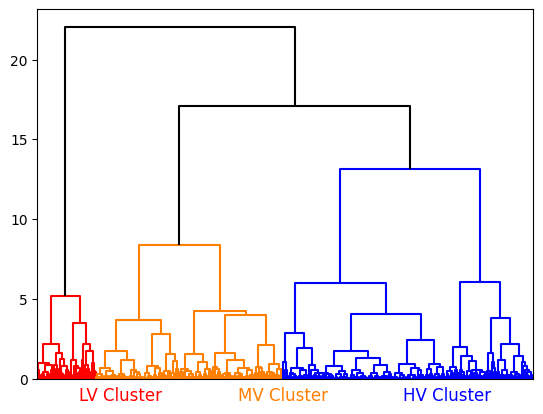

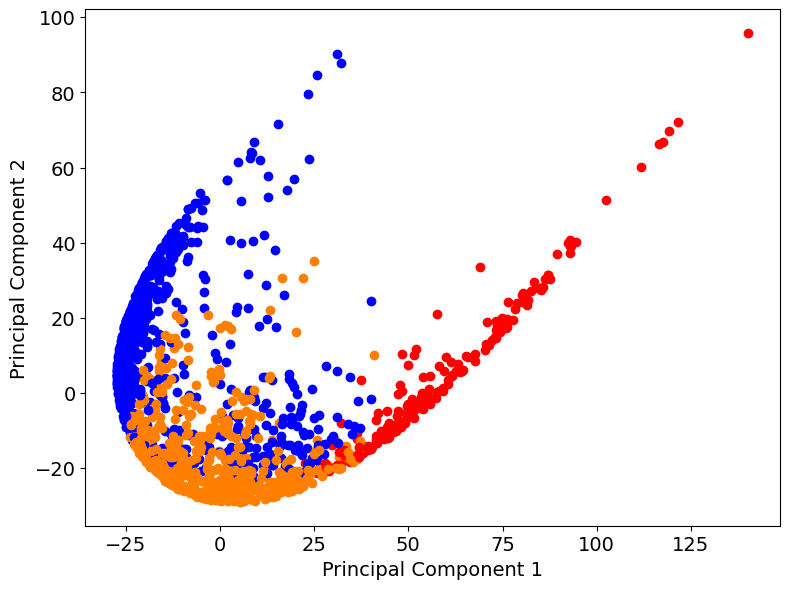

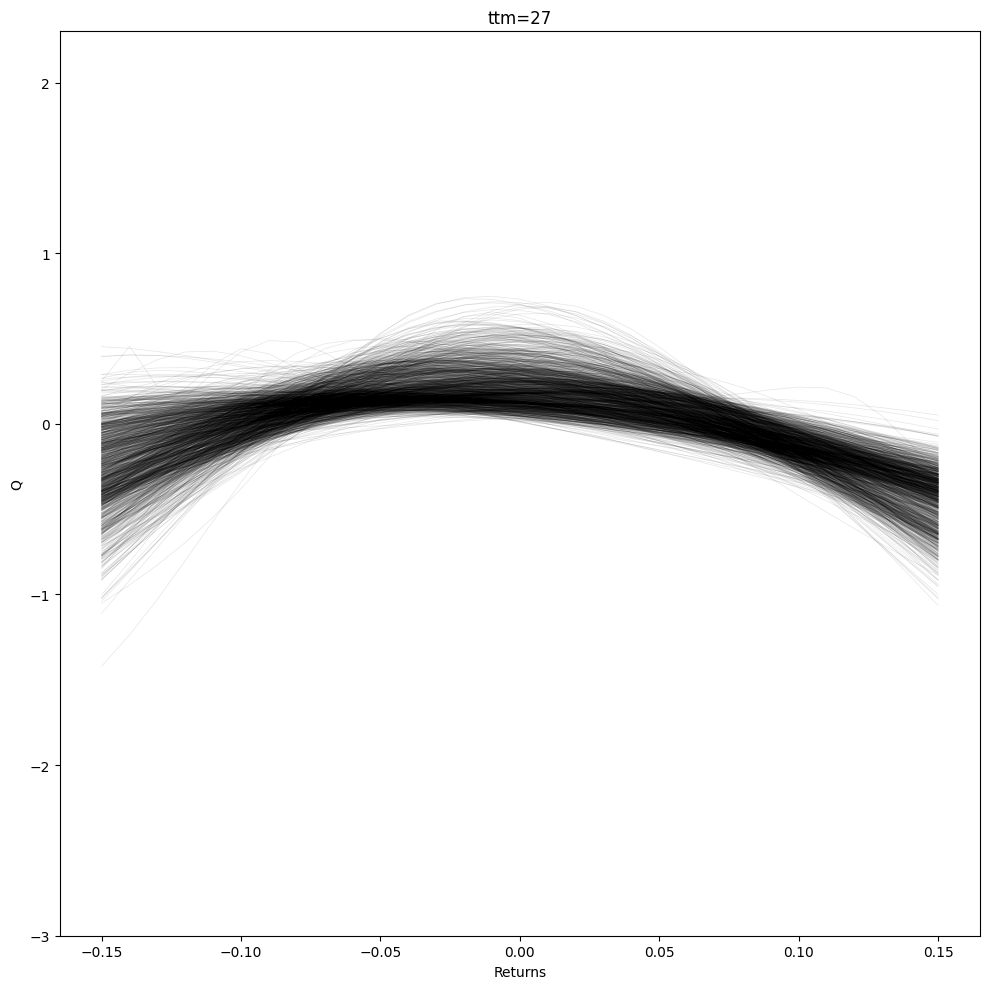

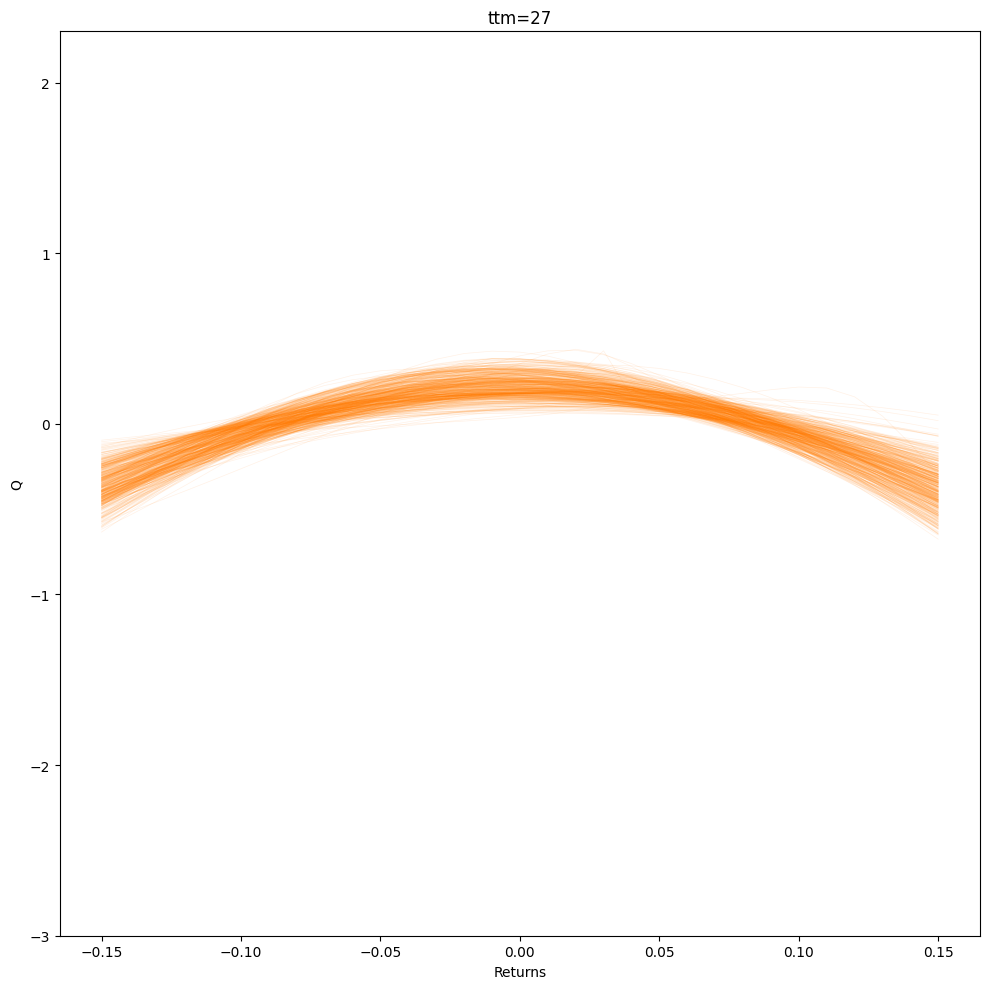

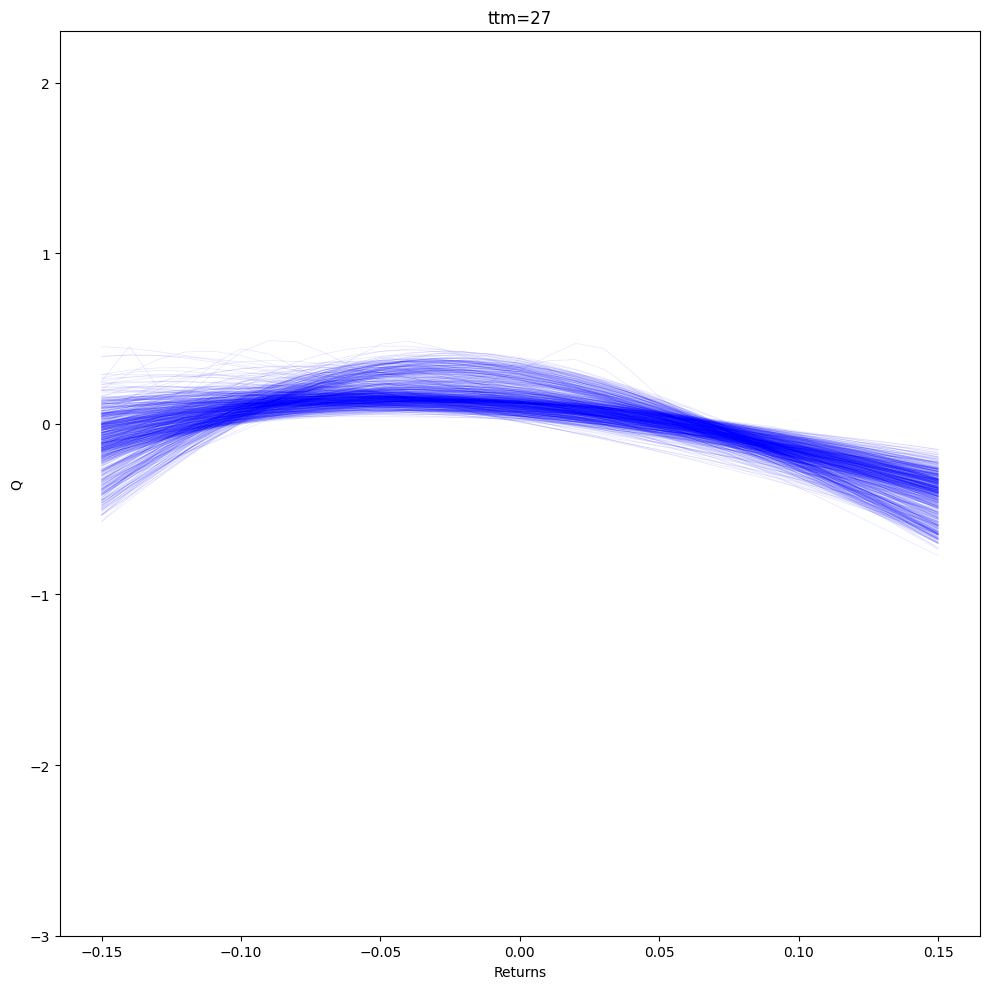

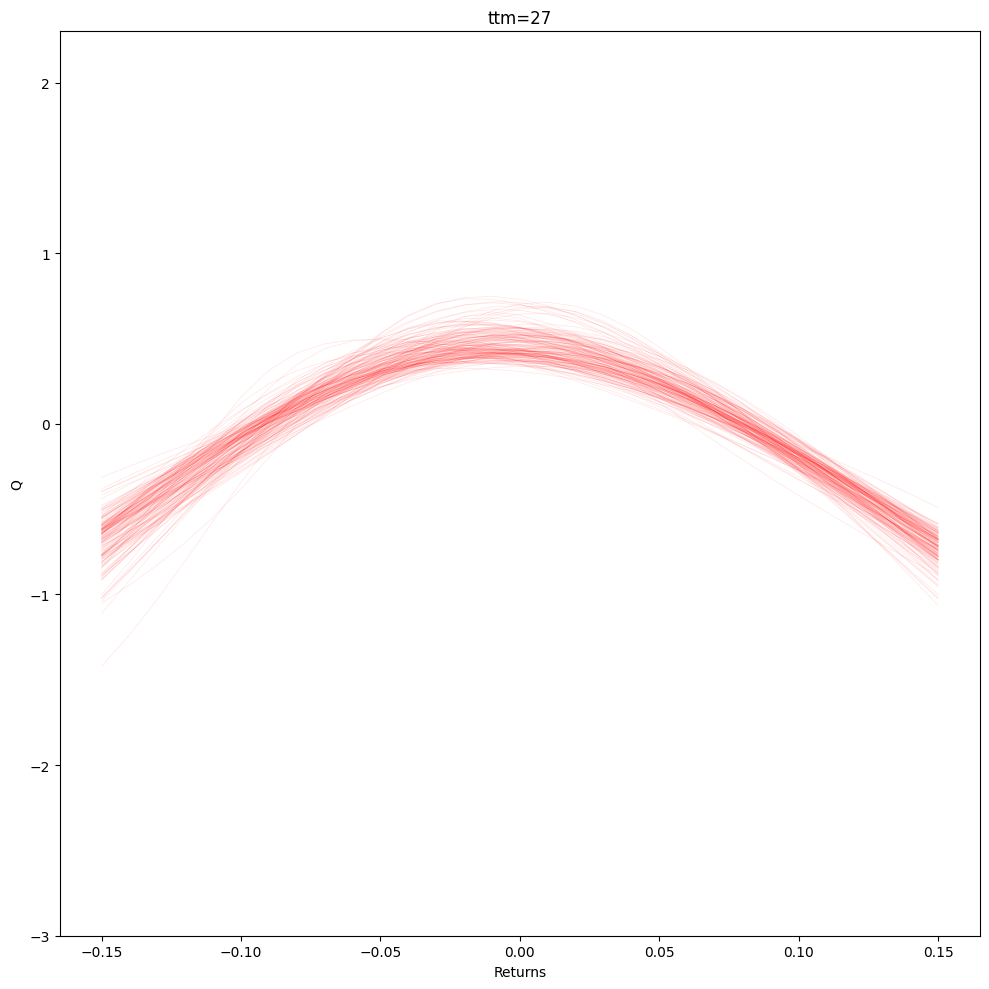

In [21]:
for name in list(globals()):
    if not name.startswith('_'):
        del globals()[name]


import pandas as pd
import os
import numpy as np
from scipy.stats.mstats import gmean
import scipy
from scipy.spatial import distance_matrix
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cut_tree
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from cycler import cycler

# =======================================================
# Load the Q vectors and find common columns
# =======================================================

# Get the default property cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Set the first three colors to orange, blue, and red, respectively
new_colors = ['#000000', '#FF0000', '#FF7F00', '#0000FF'] + default_colors[3:]
# Set the new property cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=new_colors)
#path="/Users/ratmir/Desktop/Clustering Zijin New"
path="/Users/irtg/Documents/Github/BTC-premia/SVI_independent_tau/"
os.chdir(path)
univariate_cluster_path = os.path.join(path, "Clustering", "Tau-independent", "unique", "moneyness_step_0d01","univariate_clustering")
os.makedirs(univariate_cluster_path, exist_ok=True)
# Load the Q vectors from the four different time-to-maturity (ttm) periods
df1 = pd.read_csv(os.path.join(path, "Q_matrix", "Tau-independent", "unique", "moneyness_step_0d01",'Q_matrix_27day_d15.csv'))
# Get the column names from each DataFrame
columns1 = list(df1.columns)[1:]

# Find common columns, preserving the order based on the first DataFrame
common_columns = [col for col in columns1]
# Print all column lists and the common columns
print("Common date columns:", common_columns)

# =======================================================
# CLR Transformation as the paper: log(x) - log(gmean(x))
# =======================================================
def clr(x):
   return np.log(x) - np.log(gmean(x))
df1_clr = clr(df1.drop(['Return'], axis=1))

# =====================================================================================================================
# Calculate the pairwise multivariate Euclidean distances between the rows of this new matrix. Do the clustering.
# =====================================================================================================================
concatenated_vectors = []
# Loop through each common date
for date in common_columns:
   # Extract the columns (returns for the given date) from each DataFrame
   vec1 = df1_clr[date].to_numpy()

   # Concatenate only one vector, instead of four in multivariate clustering
   concatenated_vector = vec1

   # Append this concatenated vector to the list
   concatenated_vectors.append(concatenated_vector)
concatenated_matrix = np.array(concatenated_vectors)
distance_matrix_flat = scipy.spatial.distance.pdist(concatenated_matrix, 'euclidean')
Z = sch.linkage(distance_matrix_flat, method='ward')
cluster_labels = cut_tree(Z, height=15).T # The height has to be updated accordingly

# =======================
# Plot the dendrogram
# =======================
dendrogram_data = sch.dendrogram(Z)
plt.xticks([])
# Get the x-coordinates of the leaves (i.e., the original observations)
leaf_x_positions = dendrogram_data['icoord']
# Calculate mean x-position for each cluster's leaves to find a representative x-position for the cluster label
mean_x_positions = [np.mean(xs) for xs in leaf_x_positions]
cluster_0_x_pos = np.mean(mean_x_positions[:len(mean_x_positions)//3])
cluster_1_x_pos = np.mean(mean_x_positions[len(mean_x_positions)//3:len(mean_x_positions)//3*2])
cluster_2_x_pos = np.mean(mean_x_positions[len(mean_x_positions)//3*2:])
# Add custom labels "C0" and "C1" at the data-driven x-positions
plt.text(x=cluster_0_x_pos, y=-1, s="LV Cluster", ha='center', va='center', fontsize=12, color='#FF0000')
plt.text(x=cluster_1_x_pos, y=-1, s="MV Cluster ", ha='center', va='center', fontsize=12, color='#FF7F00')
plt.text(x=cluster_2_x_pos, y=-1, s="HV Cluster ", ha='center', va='center', fontsize=12, color='#0000FF')
plt.savefig(os.path.join(univariate_cluster_path,'Dendrogram.png'))
plt.show()
ss= cut_tree(Z, n_clusters = 3).T
np.unique(ss, return_counts=True)

# =======================================
# PCA ANALSIS OF THE DISTANCE MATRIX
# =======================================

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
dist_matrix = squareform(pdist(concatenated_matrix, 'euclidean'))
# 2D plot of the principal components of the distance matrix
# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dist_matrix)
# Step 2: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Plotting the 2D principal components
plt.figure(figsize=(8, 6))
colors = ['#0000FF', "#FF7F00", '#FF0000']  # Define colors for each cluster
labels = ['HV Cluster', "MV Cluster", 'LV Cluster']  # Custom labels for each cluster

cluster_labels = np.array(cluster_labels).flatten()  # Convert cluster_labels to a 1D array
for i in range(len(X_pca)):
    cluster_idx = cluster_labels[i]
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color=colors[cluster_idx], label=labels[cluster_idx])
# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(univariate_cluster_path,'PCA.png'))
plt.show()

# =======================================================
# Plot the common Q vectors for each ttm, both clusters
# =======================================================
df1_clr_com = df1_clr[common_columns]
returns = df1['Return']
plt.figure(figsize=(10, 10))
plt.plot(returns, df1_clr_com, color='black', linewidth=0.5, alpha=0.1)
plt.xlabel('Returns')
plt.ylabel('Q')
plt.title('ttm=27')

# Set y-axis limits
plt.ylim(-3, 2.3)
plt.tight_layout()
plt.show()

# =======================================================
# Plot the common Q vectors for each ttm, Q_1 cluster
# =======================================================
# Find the indices of the columns where the binary array has a 1
zero_indices = np.where(ss == 1)[1]
# Select only the columns corresponding to the zero indices
selected_columns = [common_columns[i] for i in zero_indices if i < len(common_columns)]
plt.figure(figsize=(10, 10))
plt.plot(returns, df1_clr_com[selected_columns], color='#FF7F00', linewidth=0.5, alpha=0.1)
plt.xlabel('Returns')
plt.ylabel('Q')
plt.title('ttm=27')
plt.ylim(-3, 2.3)
plt.tight_layout()
plt.show()

# =======================================================
# Plot the common Q vectors for each ttm, Q_0 cluster
# =======================================================
# Find the indices of the columns where the binary array has a 0
zero_indices = np.where(ss == 0)[1]
# Select only the columns corresponding to the zero indices
selected_columns = [common_columns[i] for i in zero_indices if i < len(common_columns)]
plt.figure(figsize=(10, 10))
plt.plot(returns, df1_clr_com[selected_columns], color='blue', linewidth=0.5, alpha=0.1)
plt.xlabel('Returns')
plt.ylabel('Q')
plt.title('ttm=27')
plt.ylim(-3, 2.3)
plt.tight_layout()
plt.show()

# =======================================================
# Plot the common Q vectors for each ttm, Q_2 cluster
# =======================================================
# Find the indices of the columns where the binary array has a 2
zero_indices = np.where(ss == 2)[1]
# Select only the columns corresponding to the zero indices
selected_columns = [common_columns[i] for i in zero_indices if i < len(common_columns)]
plt.figure(figsize=(10, 10))
plt.plot(returns, df1_clr_com[selected_columns], color='red', linewidth=0.5, alpha=0.1)
plt.xlabel('Returns')
plt.ylabel('Q')
plt.title('ttm=27')
plt.ylim(-3, 2.3)
plt.tight_layout()
plt.show()


In [22]:
print(ss)

[[0 0 0 ... 1 1 1]]


In [23]:
print(cluster_labels)

[0 0 0 ... 1 1 1]


In [24]:
print(common_columns)

['2017-07-01', '2017-07-02', '2017-07-10', '2017-08-02', '2017-08-18', '2017-08-20', '2017-09-04', '2017-09-05', '2017-09-06', '2017-09-09', '2017-09-10', '2017-09-19', '2017-10-05', '2017-10-21', '2017-10-28', '2017-10-29', '2017-11-08', '2017-11-26', '2017-12-29', '2017-12-30', '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-13', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-29', '2018-01-30', '2018-02-02', '2018-02-03', '2018-02-07', '2018-02-09', '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-18', '2018-02-19', '2018-02-23', '2018-02-24', '2018-02-26', '2018-02-27', '2018-03-02', '2018-03-03', '2018-03-05', '2018-03-06', '2018-03-08', '2018-03-10', '2018-03-14', '2018-03-16', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-23', '2018-03-24', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-15', '2018-04-16', '2018

In [25]:
df_common_dates_cluster = pd.DataFrame({'Date': common_columns, 'Cluster': cluster_labels})
print(df_common_dates_cluster)

            Date  Cluster
0     2017-07-01        0
1     2017-07-02        0
2     2017-07-10        0
3     2017-08-02        0
4     2017-08-18        0
...          ...      ...
1433  2022-10-25        1
1434  2022-10-26        1
1435  2022-10-27        1
1436  2022-10-28        1
1437  2022-10-29        1

[1438 rows x 2 columns]


In [26]:
df_common_dates_cluster.to_csv(os.path.join(univariate_cluster_path, "common_dates_cluster.csv"), index=False)

### 3D PCA

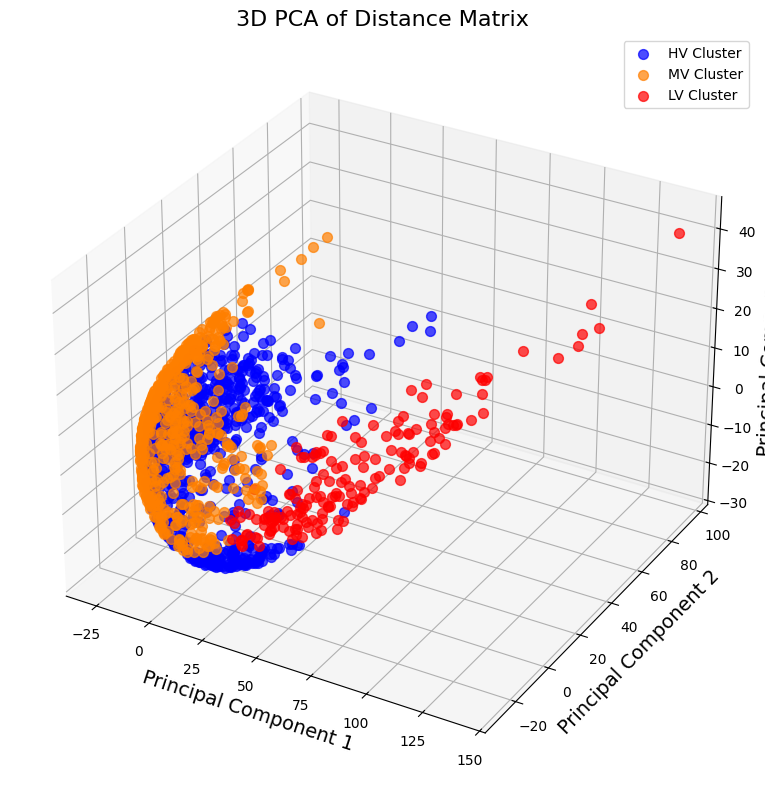

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Compute distance matrix
dist_matrix = squareform(pdist(concatenated_matrix, 'euclidean'))

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dist_matrix)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['#0000FF', "#FF7F00", '#FF0000']  # Define colors for each cluster
labels = ['HV Cluster', "MV Cluster", 'LV Cluster']  # Custom labels for each cluster

cluster_labels = np.array(cluster_labels).flatten()  # Convert to 1D array
for i in range(len(X_pca)):
    cluster_idx = cluster_labels[i]
    ax.scatter(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], 
               color=colors[cluster_idx], label=labels[cluster_idx], s=50, alpha=0.7)

# Avoid duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

# Labels and title
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)
ax.set_title('3D PCA of Distance Matrix', fontsize=16)

# Show plot
plt.tight_layout()
plt.savefig(os.path.join(univariate_cluster_path, 'PCA_3D.png'))
plt.show()